### Importing the packages

In [2]:
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
from tqdm import tqdm

from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score #scoring
import matplotlib.pyplot as plt
from matplotlib import animation, colors

import math
import random
import seaborn as sb

### Loading Data

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [4]:
batch_size = 32

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_data,batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setting up the Feature Extractor

In [6]:
feature_extractor = resnet34(weights="DEFAULT")
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
  param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

### Finding Centers using Minibatch K-Means

In [7]:
kmeans =  MiniBatchKMeans(n_clusters=20, max_iter=100, random_state=0, batch_size=batch_size)

for x_train, y_train in tqdm(train_dataloader, desc=f"Training", colour="blue"):
    x_train, y_train = x_train.to(device), y_train.to(device)
    x = feature_extractor(x_train)
    x = x.cpu()
    kmeans = kmeans.partial_fit(x)

Training:   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Training: 100%|██████████| 1563/1563 [00:57<00:00, 27.36it/s]


In [8]:
centers = torch.from_numpy(kmeans.cluster_centers_.copy())

### calculating dmax for rbf radius

In [9]:
def max_distance_between_vectors(centers):
    num_vectors = centers.shape[0]
    max_distance = 0.0

    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            distance = torch.norm(centers[i] - centers[j])
            max_distance = max(max_distance, distance)

    return max_distance

dmax = max_distance_between_vectors(centers)

print(f"The maximum distance between any two vectors is: {dmax}")

The maximum distance between any two vectors is: 56.52018892827413


### RBF Layer

In [10]:
class RBF_Layer:
    def __init__(self, n_inputs, n_neurons, centers, dmax):
      self.centers = centers # shape: (n_neurons, n_features)
      self.centers = self.centers.to(device)
      self.sigma = (((dmax / math.sqrt(2 * centers.shape[0]))) * torch.ones((1, n_neurons))) ** 2
      self.sigma = self.sigma.to(device)

    def forward(self, x):
      self.inputs = x
      self.inputs = self.inputs.to(device)
      # in_v (32 * 512) - w_v (20 * 512) = diff (32 * 20 * 512)
      self.diff = self.inputs.unsqueeze(1) - self.centers.unsqueeze(0)
      self.diff = self.diff.to(device)
      # net_v (32 * 20)
      self.l2_norm = torch.cdist(self.inputs.float(), self.centers.float(), p=2)
      self.l2_norm  = self.l2_norm.to(device)
      # calculate the exponential term
      self.output = torch.exp(-(self.l2_norm ** 2) / (2 * self.sigma)) # shape: (batch_size, n_neurons)
      self.output = self.output.to(device)
      # output (32 * 20)
      return self.output

    def backward(self, output_error):
        H = - self.diff / self.l2_norm.unsqueeze(2) # 32 * 20 * 512
        self.centers_grad = torch.sum(output_error.unsqueeze(2) * ((-self.l2_norm/self.sigma)* self.output).unsqueeze(2) * H, dim=0) / 32
        self.centers_grad = self.centers_grad.to(device)

        self.sigma_grad = torch.sum(output_error * (self.l2_norm / (2*(self.sigma**2))) * self.output, dim=0) / 32
        self.sigma_grad = self.sigma_grad.to(device)

### Linear Output Layer

In [11]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = torch.randn(n_inputs, n_neurons)
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)

    def forward(self, inputs):
        self.inputs = inputs.float()
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Softmax

In [12]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs

### Categorical Cross Entropy Loss

In [13]:
class Categorical_Cross_Entropy_loss:
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [14]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate=learning_rate
    
    def __call__(self, layer):
        if type(layer).__name__ == 'Dense':

          layer.weights = layer.weights.to(device)
          layer.biases = layer.biases.to(device)

          layer.weights -=  self.learning_rate*layer.weights_grad.to(device)
          layer.biases -= self.learning_rate * layer.biases_grad.to(device)

        elif type(layer).__name__ == 'RBF_Layer':

          layer.centers = layer.centers.to(device)
          layer.sigma = layer.sigma.to(device)

          layer.centers = layer.centers - self.learning_rate * layer.centers_grad.to(device)
          layer.sigma = layer.sigma - self.learning_rate * layer.sigma_grad.to(device)

### Architecture

In [15]:
#model
Layer1 = RBF_Layer(num_features, 20, centers, dmax)
Layer2 = Dense(20, 10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate = 0.1)

In [16]:
train_acc = []
train_loss =[]
test_loss = []
test_acc = []

In [17]:
epochs = 20
y_predtr= torch.zeros(0,dtype=torch.long, device=device)
y_true_train = torch.zeros(0,dtype=torch.long, device=device)
y_predts= torch.zeros(0,dtype=torch.long, device=device)
y_true_test = torch.zeros(0,dtype=torch.long, device=device)
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_test_loss = 0
    epoch_test_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics

        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy.item()
        if epoch == epochs-1:
            y_predtr=torch.cat([y_predtr,y_predict_train.view(-1)])
            y_true_train=torch.cat([y_true_train,y_train.view(-1)])
        # Backward pass
        x = Loss.backward(y_train)
        x = Layer2.backward(x)
        Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1)
        Optimizer(Layer2)

    with torch.no_grad():
        for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
                # Forward pass
                x_test, y_test = x_test.to(device), y_test.to(device)
                x = feature_extractor(x_test)
                x = Layer1.forward(x)
                x = Layer2.forward(x)
                x = Act2.forward(x)
                loss = Loss.forward(x, y_test)

                # Report batch metrics
                y_predict_test = torch.argmax(x, dim=1)
                accuracy = torch.mean((y_test == y_predict_test).float())
                epoch_test_loss += loss.item()
                epoch_test_accuracy += accuracy.item()
                if epoch == epochs-1:
                    y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
                    y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
    # Report epoch metrics
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    epoch_test_loss /= len(test_dataloader)
    epoch_test_accuracy /= len(test_dataloader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_accuracy)
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {epoch_train_loss:.7f}')
    print(f'Train Accuracy: {epoch_train_accuracy:.7f}')
    print(f'Test Loss: {epoch_test_loss:.7f}')
    print(f'Test Accuracy: {epoch_test_accuracy:.7f}')
    print('--------------------------')


Testing: 100%|██████████| 313/313 [00:05<00:00, 60.10it/s]


Epoch: 1
Train Loss: 2.3058477
Train Accuracy: 0.1062860
Test Loss: 2.3043384
Test Accuracy: 0.0911542
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 59.71it/s]


Epoch: 2
Train Loss: 2.2997651
Train Accuracy: 0.1113044
Test Loss: 2.2987066
Test Accuracy: 0.1206070
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 60.70it/s]


Epoch: 3
Train Loss: 2.2948704
Train Accuracy: 0.1161828
Test Loss: 2.2931747
Test Accuracy: 0.1201078
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 60.04it/s]


Epoch: 4
Train Loss: 2.2905320
Train Accuracy: 0.1269394
Test Loss: 2.2894733
Test Accuracy: 0.1145168
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 59.75it/s]


Epoch: 5
Train Loss: 2.2862339
Train Accuracy: 0.1335972
Test Loss: 2.2835582
Test Accuracy: 0.1288938
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 57.72it/s]


Epoch: 6
Train Loss: 2.2830229
Train Accuracy: 0.1388756
Test Loss: 2.2793811
Test Accuracy: 0.1475639
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 60.50it/s]


Epoch: 7
Train Loss: 2.2798678
Train Accuracy: 0.1416947
Test Loss: 2.2774402
Test Accuracy: 0.1445687
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 61.71it/s]


Epoch: 8
Train Loss: 2.2772260
Train Accuracy: 0.1444938
Test Loss: 2.2752085
Test Accuracy: 0.1577476
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 60.89it/s]


Epoch: 9
Train Loss: 2.2745159
Train Accuracy: 0.1505118
Test Loss: 2.2718308
Test Accuracy: 0.1507588
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 53.83it/s]


Epoch: 10
Train Loss: 2.2723450
Train Accuracy: 0.1495721
Test Loss: 2.2698358
Test Accuracy: 0.1517572
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 59.90it/s]


Epoch: 11
Train Loss: 2.2708110
Train Accuracy: 0.1540307
Test Loss: 2.2669245
Test Accuracy: 0.1501597
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.62it/s]


Epoch: 12
Train Loss: 2.2692693
Train Accuracy: 0.1538308
Test Loss: 2.2671532
Test Accuracy: 0.1500599
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 53.50it/s]


Epoch: 13
Train Loss: 2.2678989
Train Accuracy: 0.1537308
Test Loss: 2.2662189
Test Accuracy: 0.1598442
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 56.34it/s]


Epoch: 14
Train Loss: 2.2666426
Train Accuracy: 0.1537508
Test Loss: 2.2656372
Test Accuracy: 0.1555511
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.04it/s]


Epoch: 15
Train Loss: 2.2657149
Train Accuracy: 0.1560901
Test Loss: 2.2625727
Test Accuracy: 0.1609425
--------------------------


Testing: 100%|██████████| 313/313 [00:06<00:00, 47.51it/s]


Epoch: 16
Train Loss: 2.2634897
Train Accuracy: 0.1575896
Test Loss: 2.2617087
Test Accuracy: 0.1596446
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 52.52it/s]


Epoch: 17
Train Loss: 2.2639592
Train Accuracy: 0.1565699
Test Loss: 2.2599322
Test Accuracy: 0.1644369
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 53.78it/s]


Epoch: 18
Train Loss: 2.2619317
Train Accuracy: 0.1572897
Test Loss: 2.2595563
Test Accuracy: 0.1497604
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 57.25it/s]


Epoch: 19
Train Loss: 2.2611328
Train Accuracy: 0.1584293
Test Loss: 2.2590773
Test Accuracy: 0.1638379
--------------------------


Testing: 100%|██████████| 313/313 [00:05<00:00, 59.67it/s]

Epoch: 20
Train Loss: 2.2600526
Train Accuracy: 0.1596089
Test Loss: 2.2545381
Test Accuracy: 0.1593450
--------------------------


In [ ]:
import torch
X = torch.rand(32, 512) # a tensor with shape 32*512
A = torch.rand(20, 512) # a tensor with shape 512*20
D = torch.cdist(X, A, p=2) # a tensor with shape 32*20
print(D.shape)
#print(D)
print((D/sigma).shape)

In [ ]:
import torch
B = torch.rand(32, 512) # a tensor with shape 32*512
C = torch.rand(20, 512) # a tensor with shape 20*512
B_expanded = B.unsqueeze(1) # a tensor with shape 32*1*512
C_expanded = C.unsqueeze(0) # a tensor with shape 1*20*512
G = B_expanded - C_expanded # a tensor with shape 32*20*512

D_expanded = D.unsqueeze(2) # a tensor with shape 32*20*1
H = G / D_expanded # a tensor with shape 32*20*512
print(H.shape)


In [ ]:
U = torch.rand(32,20)
K = torch.exp(U)*H/(sigma)

NameError: name 'sb' is not defined

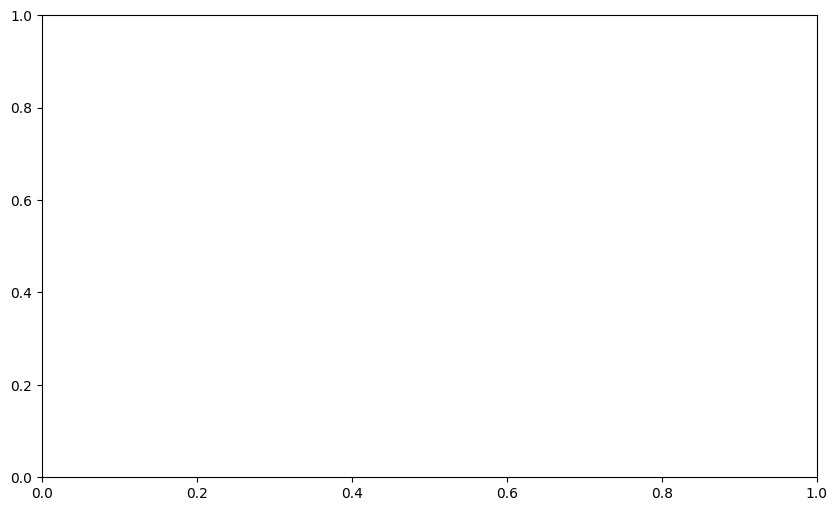

In [18]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predtr.data.cpu().numpy()
y_train_numpy = y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()

